# T3: Mutiple-sample modeling: J20 Alzheimer's mouse model

In [1]:
import scanpy as sc
import torch
import urllib.request
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from diffusers import DDPMScheduler
from torch_geometric.loader import NeighborLoader
from stadiffuser import pipeline
from stadiffuser.vae import SpaAE
from stadiffuser.models import SpaUNet1DModel
from stadiffuser import utils as sutils
from stadiffuser import metrics
warnings.filterwarnings("ignore")

## Load adata

In [2]:
# load processed Slide-seq V2 data
url = "https://drive.google.com/uc?export=download&id=1MiQMGAE4a4cf3uj1DHiZTZERmmvBjiKd"
urllib.request.urlretrieve(url, "adata_slice1_J20.h5ad")
url = "https://drive.google.com/uc?export=download&id=1mxX5_K5oAtJJCu_RRTacG2PGtYQ3PIGs"
urllib.request.urlretrieve(url, "adata_slice2_J20.h5ad")

('adata_slice2_J20.h5ad', <http.client.HTTPMessage at 0x1e6a5b13f40>)

If encounter problems in download datasets. Please manually download from the following links:
- `adata_slice1_J20`: https://drive.google.com/file/d/1MiQMGAE4a4cf3uj1DHiZTZERmmvBjiKd/view?usp=drive_link
-  `adata_slice_2J20`: https://drive.google.com/file/d/1mxX5_K5oAtJJCu_RRTacG2PGtYQ3PIGs/view?usp=drive_link

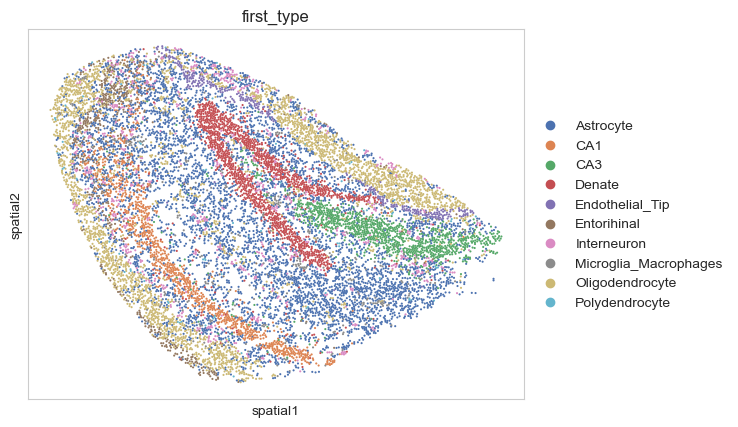

AnnData object with n_obs × n_vars = 12918 × 2455
    obs: 'spot_class', 'first_type', 'second_type', 'first_class', 'second_class', 'min_score', 'singlet_score', 'conv_all', 'conv_doublet'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'first_type_colors', 'hvg', 'log1p', 'spatial_net'
    obsm: 'spatial'

In [8]:
adata1 = sc.read("adata_slice1_J20.h5ad")
sc.pl.embedding(adata1, basis="spatial", color="first_type")
adata1

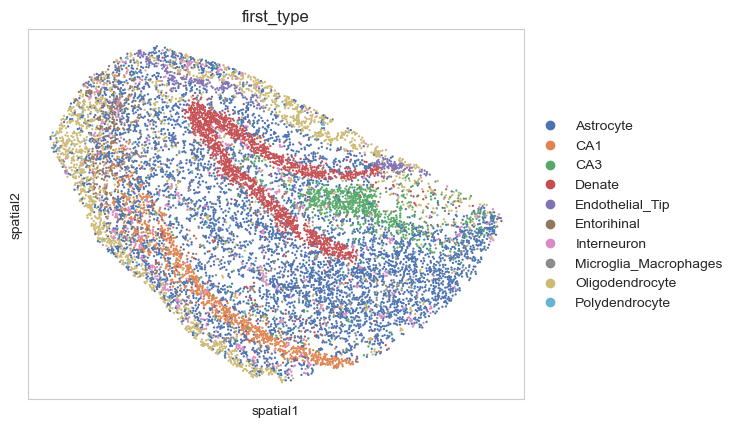

AnnData object with n_obs × n_vars = 10998 × 2455
    obs: 'spot_class', 'first_type', 'second_type', 'first_class', 'second_class', 'min_score', 'singlet_score', 'conv_all', 'conv_doublet'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'first_type_colors', 'hvg', 'log1p', 'spatial_net'
    obsm: 'spatial'

In [9]:
adata2 = sc.read("adata_slice2_J20.h5ad")
sc.pl.embedding(adata2, basis="spatial", color="first_type")
adata2

In [14]:
adata_multi = adata1.concatenate(adata2, batch_key="replicate")
adata_multi.obs["replicate"].value_counts()

replicate
0    12918
1    10998
Name: count, dtype: int64

In [15]:
adata_multi = sutils.cal_spatial_net3D(adata_multi, iter_comb=None, batch_id="replicate", rad_cutoff=30,
                                add_key="spatial_net")
new_spatial = adata_multi.obsm["spatial"].copy()
new_spatial = sutils.quantize_coordination(new_spatial, methods=[("division", 60), ("division", 60)])
adata_multi.obsm["new_spatial"] = new_spatial

------Calculating spatial network for each batch...
Calculating spatial network for batch 0...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 78888 edges, 12918 cells, 6.1068 neighbors per cell on average.
Calculating spatial network for batch 1...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 62910 edges, 10998 cells, 5.7201 neighbors per cell on average.
------Calculating spatial bipartite network...
------Spatial network calculated.
Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.016666666666666666, mean deviation: 0.2507799134097571, pearson correlation: 0.9997683852286801
Quantize 1th dimension of spatial coordinates to 0.016666666666666666, mean deviation: 0.24873965287331729, pearson correlation: 0.9997052613724746


## Training autoencoder

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = SpaAE(input_dim=adata_multi.shape[1],
                        block_list=["AttnBlock"],
                        gat_dim=[512, 32],
                        block_out_dims=[32, 32])

### Pratraining on each slice

In [19]:
from stadiffuser.dataset import  get_slice_loader
batch_list = ["0", "1"]
data = pipeline.prepare_dataset(adata_multi, use_rep=None)
train_loaders = [get_slice_loader(adata_multi, data, batch, use_batch="replicate",
                                  batch_size=256) for batch in batch_list]
autoencoder, autoencoder_loss = pipeline.pretrain_autoencoder_multi(train_loaders,
                                                                    autoencoder,
                                                                    pretrain_epochs=200,
                                                                    device=device)

  0%|          | 0/200 [00:00<?, ?it/s]

### Training with triplet loss

In [22]:
autoencoder, autoencoder_loss = pipeline.train_autoencoder_multi(adata_multi, autoencoder, use_batch="replicate",
                                                                 batch_list=batch_list,
                                                                 n_epochs=300,
                                                                 margin=1,
                                                                 lr=1e-4,
                                                                 update_interval=50,
                                                                 device=device)

  0%|          | 0/300 [00:00<?, ?it/s]

## Training Latent diffusion model

In [20]:
import numpy as np
label_name = "first_type"
num_class_embeds = len(np.unique(adata_multi.obs[label_name]))
class_dict = dict(zip(np.unique(adata_multi.obs[label_name]), range(num_class_embeds)))
class_dict

{'Astrocyte': 0,
 'CA1': 1,
 'CA3': 2,
 'Denate': 3,
 'Endothelial_Tip': 4,
 'Entorihinal': 5,
 'Interneuron': 6,
 'Microglia_Macrophages': 7,
 'Oligodendrocyte': 8,
 'Polydendrocyte': 9}

In [23]:
adata_multi = pipeline.get_recon(adata_multi, autoencoder, device=device,
                           apply_normalize=False, show_progress=True, batch_mode=True)
normalizer = sutils.MinMaxNormalize(adata_multi.obsm["latent"], dim=0)
adata_multi.obsm["normalized_latent"] = normalizer.normalize(adata_multi.obsm["latent"])

  0%|          | 0/94 [00:00<?, ?it/s]

In [29]:
denoiser = SpaUNet1DModel(in_channels=17, out_channels=1, num_class_embeds=num_class_embeds).to(device)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
adata_multi.obs["label_"] = adata_multi.obs[label_name].map(class_dict)
data_latent = pipeline.prepare_dataset(adata_multi, use_rep="normalized_latent", use_spatial="new_spatial",
                                       use_net="spatial_net", use_label="label_")
train_loader = NeighborLoader(data_latent, num_neighbors=[5, 3], batch_size=256)
denoiser, denoise_loss = pipeline.train_denoiser(train_loader, denoiser, noise_scheduler,
                                                 lr=1e-4, weight_decay=1e-6,
                                                 n_epochs=500,
                                                 num_class_embeds=num_class_embeds,
                                                 model_name="denoiser_{}".format(label_name),
                                                 device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

-------------------Training Finished-------------------


## Simulate from the trained STADiffuser model

In [42]:
# simulate replicate1 with the trained models
adata1 = adata_multi[adata_multi.obs["replicate"] == "0"].copy()
adata1 = sutils.cal_spatial_net2D(adata1, rad_cutoff=30, add_key="spatial_net")
adata1.obs["labels_"] = adata_multi
data = pipeline.prepare_dataset(adata1, use_net="spatial_net", use_spatial="new_spatial")
stadiff_sim = pipeline.simulate(denoiser, autoencoder, device=device, use_net="spatial_net",
                                ref_data=adata1, spatial_coord=adata1.obsm["new_spatial"],
                                labels = adata1.obs["label_"].to_numpy(), seed=2024, normarlizer=normalizer)

------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 78888 edges, 12918 cells, 6.1068 neighbors per cell on average.
Simulate with labels


  0%|          | 0/1000 [00:00<?, ?it/s]

In [52]:
# sc.pl.embedding(stadiff_sim, basis="spatial", color="Axl", size=200, color_map="viridis")